# Continued

In [1]:
import pandas as pd
import json
json_data = open('../views/sample/input00.in') # Edit this to where you have put the input00.in file

data = []
for line in json_data:
    data.append(json.loads(line))

data.remove(9000)
data.remove(1000)

df = pd.DataFrame(data)
cleaned_df=pd.DataFrame(data[0:9000])
data_df = cleaned_df.copy()

In [2]:
# extra libraries
from plotnine import *

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# More Text Analysis

In [3]:
# The 75th and 90th percentile of the `__ans__` column.
data_df['__ans__'].quantile([0.75, 0.9])

0.75     4.019578
0.90    12.787143
Name: __ans__, dtype: float64

Let's analyze the frequency of words that show up in question texts that have `__ans__` in the 75th or above percentile

In [4]:
# svf stands for seventy-fifth
svf_words = data_df[data_df.__ans__ >= 4.019578][['question_text']].question_text.values
svf_words = ' '.join(svf_words).split()
svf_unique_words = sorted(set(svf_words))

In [5]:
svf_list = [] 
for word in svf_unique_words:
    if len(word) >= 3:
        a = [int(svf_words.count(word)), str(word)]
        svf_list.append(a)

svf_list_df = pd.DataFrame(svf_list, columns=['freq', 'word']).sort_values(by=['freq'], ascending=False)
svf_list_df.describe()

,freq
count,7615.000000
mean,3.025476
std,21.722844
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1275.000000


Since it's an intensive task to create a correlation on each of the 7615 words, most of which only appear once anyway, let's instead just work with the most frequent 1,000 words. 

In [6]:
# first sort the whole thing
svf_list_df = pd.DataFrame(svf_list, columns=['freq', 'word']).sort_values(by=['freq'], ascending=False)

# pick out the most frequent 1000 words
svf_words_freq_sorted = svf_list_df['word'][:1000].sample(frac=1) # the `sample` method randomizes all the rows (frac=1) after picking the top 1000

In [169]:
# convert in to an array
svf_list_ = svf_words_freq_sorted.values 
svf_list_[0:30] # "head" of the array

array(['degree', 'experience?', 'way', 'buy', 'When', 'BITS', 'potential',
       'scene', 'Larry', 'sleep', 'With', 'learning?', 'regular',
       'importance', 'outside', 'Web', "don't", 'legal', 'like?', 'called',
       'university', 'progress', 'list', 'development', 'store', 'help',
       'bringing', "you've", 'sort', 'apply'], dtype=object)

To make our task even less intensive (running the analysis, which I will describe below, took longer than 15 mins on the 1000 words), let's do it in chunks. Details below. 

In [8]:
# divide svf_list_ into chunks
out = []
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

In [9]:
# the array `out` has 20 subarrays containing 50 words
chunkIt(svf_list_, 20)

We will run each word and look up the correlation.

In [10]:
# give it an index and it will return the correlation array of the words in `out[index]`
def corrIt(idx):
    var = []
    for i in range(len(out[idx])):
        a = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(out[idx][i]))) else 0)
        var.append(a.corr(data_df['__ans__']))
    return var

In [11]:
# return a sorted dataframe with words and their correlation in appearance
def dfIt(idx):
    corr_list = corrIt(idx)
    mash_df = pd.concat([pd.DataFrame(corr_list, columns=['cor']),pd.DataFrame(out[idx],
                                                                       columns=['word'])],
                   axis=1)
    return mash_df.sort_values(by='cor', ascending=False)

In [12]:
df_19=dfIt(19)
df_19.head()

,cor,word
43,0.049485,facts
7,0.042782,girl
1,0.035482,some
11,0.028302,sexual
2,0.027856,team


Would be nice to add the length and frequency.

In [13]:
def enrich(data_f):
    data_f['len'] = data_f['word'].apply(lambda x: len(x)) #adds length
    data_f['freq'] = data_f['word'].apply(lambda x: # grab frequency of the word from `svf_list_df`
                                          svf_list_df[svf_list_df['word']==x].iloc[0].freq)
    return data_f

In [14]:
enrich(df_19).head()

,cor,word,len,freq
43,0.049485,facts,5,14
7,0.042782,girl,4,10
1,0.035482,some,4,212
11,0.028302,sexual,6,5
2,0.027856,team,4,6


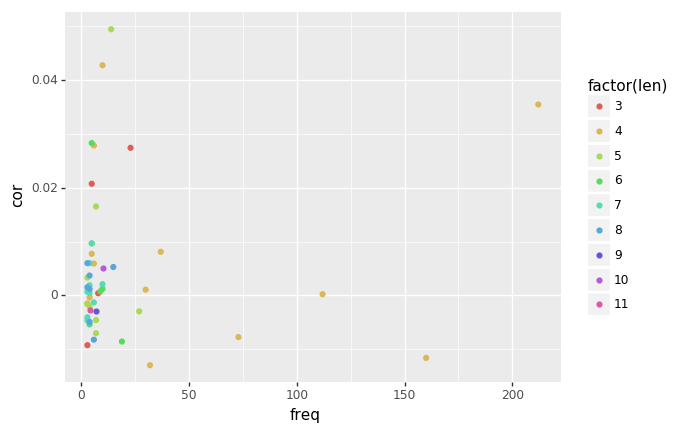

<ggplot: (-9223363266706661565)>

In [15]:
(ggplot(df_19, aes('freq', 'cor', color='factor(len)'))+ geom_point())

In [16]:
df_19['len'].value_counts(bins=4)

(2.991, 5.0]    26
(5.0, 7.0]      14
(7.0, 9.0]       8
(9.0, 11.0]      2
Name: len, dtype: int64

In [17]:
# divide length into bins
bins = [2.9, 4.9, 7.9, 12] # bins will be effectively be [3, 5) etc
group_names = ['[3, 5)', '[5-8)', '[8-12]']
df_19['len_bins'] = pd.cut(df_19.len, bins, labels=group_names)

In [18]:
df_19.head()

,cor,word,len,freq,len_bins
43,0.049485,facts,5,14,[5-8)
7,0.042782,girl,4,10,"[3, 5)"
1,0.035482,some,4,212,"[3, 5)"
11,0.028302,sexual,6,5,[5-8)
2,0.027856,team,4,6,"[3, 5)"


Now let's redo the plot.

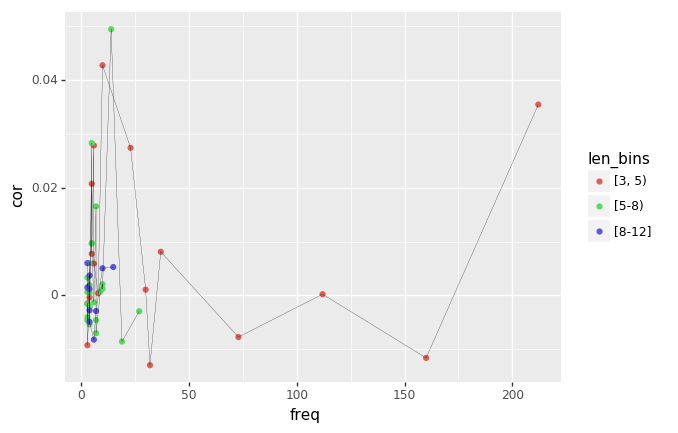

<ggplot: (-9223363266766295229)>

In [19]:
(ggplot(df_19, aes('freq', 'cor'))
     + geom_point(aes(color='len_bins'))
     + geom_line(aes(group='len_bins'), size=0.1)
)

We could use zooming into 0-50 freq as it is apparent that higher frequency words have higher correlation. 

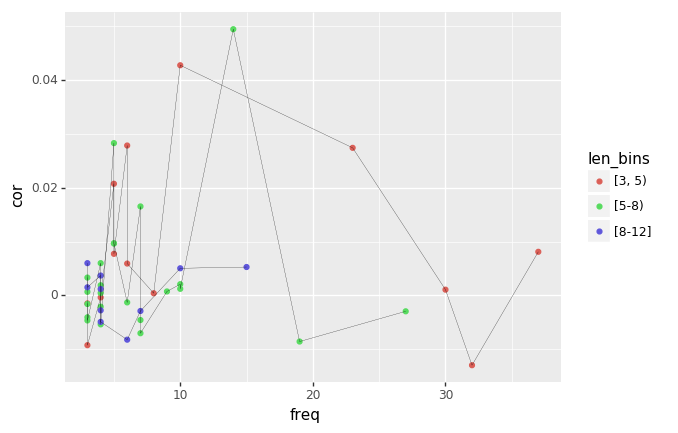

<ggplot: (-9223363266766316698)>

In [20]:

(ggplot(df_19[df_19['freq']<50], aes('freq', 'cor'))
     + geom_point(aes(color='len_bins'))
     + geom_line(aes(group='len_bins'), size=0.1)
)

So the previous conclusion hold for words that are three or four letters long.

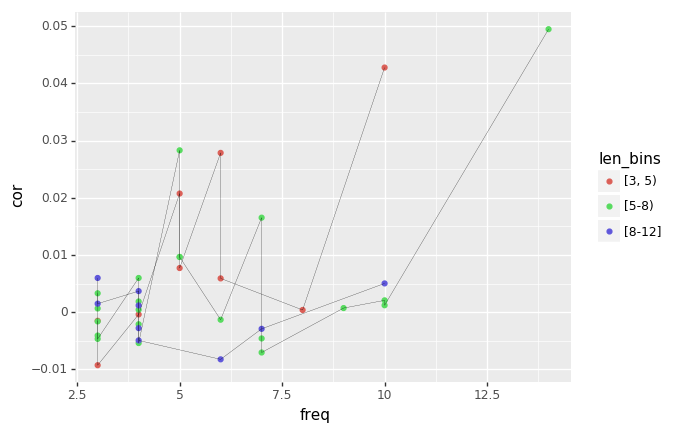

<ggplot: (8770088592732)>

In [21]:

(ggplot(df_19[df_19['freq']<15], aes('freq', 'cor'))
     + geom_point(aes(color='len_bins'))
     + geom_line(aes(group='len_bins'), size=0.1)
)

Nothing more is descernable at this point.

---

To check our work, let's go through the code. Say, we pick `out[19][2]`, the second word in the 19th slice 

In [22]:
print(out[19][2], str(out[19][2]))
data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(out[19][2]))) else 0).describe()

team team


count    9000.000000
mean        0.005000
std         0.070538
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: question_text, dtype: float64

The series has 9000 entries of zeroes and one--zero means the question text in that row doesn't contain the keyword `out[19][2]=`*research*. So, looking at the mean of the series, we can tell data points with a question text conatining this word are 0.6% of the dataset. 

On the other hand, we are calculating the correlation between `__ans__` and the above series of 0's and 1's. This effectively tells us if we should weigh question texts with the particular word more.  

Now, we will check the correlation in the remaining 19 chunks as we did with the 19th chunk. Simply run `corrIt(index)`. 

We also need to get rid of this to avoid [`multiple repeat` errors](https://docs.python.org/2/library/re.html).

In [23]:
# Searching for `\\` it only appears once as `\\sin` and `++` only appears in `C++`
for i in range(20):
    try:
        if list(out[i]).index('C++') != 999:
            print('C++ was at ', i, list(out[i]).index('C++'))
            out[i][list(out[i]).index('C++')] = 'Cpp' 
    except:
        pass

C++ was at  1 37


In [24]:
for i in range(20):
    try:
        if list(out[i]).index('\\sin') != 999:
            print('\\sin was at', i, list(out[i]).index('\\sin'))
            out[i][list(out[i]).index('\\sin')] = 'sin'
    except:
        pass

\sin was at 2 9


In [25]:
for i in range(20):
    try: 
        if list(out[i]).index('(or') != 999:
            print('(or was at ', i, list(out[i]).index('(or'))    
            out[i][list(out[i]).index('(or')] = 'or'
    except:
        pass

(or was at  14 25


### Calculate the correlation of all the lists

In [27]:
corr_big_list = []
for i in range(0,20):
    corr_big_list.append(corrIt(i))

---

Since the `out` list is randomized (see `svf_list_` section) and because computing `corr_big_list` takes quite a while, I have saved a copy of a pair of `out` and `corr_big_list` as `out_1` and `corr_big_list_1` for convenience:

In [150]:
corr_big_list_1=[[0.00030816712579101571, 0.0044730016004795375, -0.018184254245652551, -0.011636498757889403, -0.0098418778581828206, 0.026097559924847694, 0.013042976799379082, -0.0024952856521519564, -0.0014278019418653462, -0.0066361332379731679, 0.034104606674625594, -0.0035300160142935299, -0.003388724944028706, -0.00080654880511365698, 0.0064072351728142116, -0.0066817381346244509, 0.00040979589589246629, -0.010358276711574618, 0.024729665673063398, -0.0048034598229090199, 0.1023288271726879, -0.0033370673570963859, 0.035198130429207504, -0.0023873121233479811, -0.0075365026756989712, -0.0043573283771661201, -0.00091066872737137863, 0.0085851641623233832, -0.0069155008482646016, -0.0033476240638101243, -0.00033489503766559448, 0.014024682957343831, -0.0066328075447330643, 0.0077050217122674606, 0.0083476497238622431, 0.00027866044671089101, -0.0046298488103451371, 0.0094317686368927591, 0.0031286448646075495, -0.007465595807550328, -0.0062456567924396708, -0.0051985229784726949, -0.0087520730389423484, 0.0014825103568157643, 0.025447137503987683, 0.0031569477232396693, -0.007618273825201566, 0.022717987737610412, -0.0065577550547866823, 0.0024386167711497784], [-0.0028881589497217167, 0.010970003941513328, 0.0012167271461354528, -0.0021697742804818623, 0.024265919636645681, -0.00024240895328244371, -0.0034342361979813633, -0.0032547763290757593, 0.0020840162391008521, 0.016400747472871784, 0.0037064189243741956, -0.0038322475167536837, -0.0058279101130724415, -0.003531779753513931, -0.0033060631530503915, -0.0047608726154802911, -0.0015200622602567389, -0.010092491967139818, -0.0026847949372279622, -0.014343373247904022, -0.0024851015775787261, 0.0072252372611917833, 0.012332709730471519, 0.02166493696952319, 0.0020093176341874639, 0.0022830828870203054, 0.0027891198322104837, -0.0025104065772374035, -0.00055134449132394057, -0.001007314989035814, -0.0037201198144300551, 0.006633708403083834, -0.005827203317157627, 0.0027196570088708887, 0.013579865687406288, -0.0022465082543230513, 0.0017858139450578983, 0, 0.0013523228325291912, 0.0039347553975315414, 0.042502038772258076, -0.00056345496362009508, -0.0089123906202641118, -0.0029185246867027741, 0.0003741297966530131, -0.006718165630880242, -0.0038299141483705431, 0.00076828958569195448, -0.0073595881806147595, 0.0065152552923246213], [-0.0055662554304464693, 0.0021857985438673176, -0.006157833996541494, 0.020118287899894512, -0.0064322125267556015, -0.0033640023093176388, -0.0034487164022805384, 0.0010694360014762655, 0.010806860685386742, 0.019611096216255855, 0.06473026552187619, -0.007815658265600196, -0.0012049951012723396, 0.0096650532832685109, -0.0081848479110903649, 0.0024824638193696215, 0.045228364686901064, 0.020919625833423588, -0.0057262034628689897, -0.0019546889972717834, -0.0017681380449655051, 0.0019305929838144295, -0.0031441860996190675, -0.0091759626612213149, 0.0018272732681465899, -0.003419877793160774, 0.024590202172987598, -0.0071735609830342996, -0.0019238105997293742, -0.01032902061134779, 0.010247275627760207, -0.00056781109993696277, -0.0074412546495274809, 0.0022089926031274303, -0.0054321061719030551, -0.010937530508012645, 0.0050621539189750044, 0.011163850401181617, -0.00097233345353591328, -0.0067471022553516153, 0.0018617529033470284, -0.011395546776726858, 0.0036492808301568512, 0.026283788933778612, -0.0025309817485629493, -0.0082404999294812854, 0.011175686406548348, -0.00084449398642895326, -0.0038134751677193356, 0.0031286448646075495], [0.0039335300005773734, -0.0027872361334454962, 0.025109668718567041, -0.0024729319841923386, -0.0054221514177400405, -0.0046140021830209455, -0.0029644205787335356, 0.0058658412666491933, 0.0020648373671194958, -0.0030732652382889514, 0.0043183460398299178, -0.0057778457326998888, -0.0052229711454849287, -0.0087179001899529308, -0.0070100485247778727, 0.010058161838999092, -0.013467420834281653, -0.0076595558346031116, -0.006846817797872766, 0.0039897170246467667, -0.00225475456179865, 0.0013765911353118988, 0.057405017749717721, -0.01071715522122787, -0.0063368385283841403, 0.0063244299368342832, -0.0051365796481612006, 0.00025895772891952227, -0.0036898711970211047, -0.004416346605422782, -0.0073325950512096111, -0.0083767904154685175, -0.002655266274509108, 0.0040331504683418593, -0.0059432116691789738, -0.011600644473004301, -0.0027082071049287838, -0.0089337864054543428, -0.0033391570284709042, 0.0056973588788680057, -0.0041113398203742732, -0.0083833449232279429, -0.0019220847118080551, -0.0046328240228199523, 0.052146092864333041, 0.0094031766500344595, -0.0035331066727011832, 0.020810083453388445, -0.0076294707410923378, 0.01827868115925433], [-0.0040999983406437204, 0.0071064687418175591, -0.0041744351036019541, -0.0092409000028602969, 0.0083413418554632458, 0.0061532729187045278, 0.024004010174493714, 0.0082475317939110435, -0.0029356768647843911, -0.0052995819515106448, -0.0029477837556126695, -0.0059717367506664154, -0.0012952588264538371, 0.00021457496458008647, 0.028008637897122796, -0.003350012091366671, 0.0067106966916407112, -0.0017859386698853088, 0.0019353708646550583, 0.015645789981094838, 0.0067197670852938776, 0.0026522558154171249, -0.0003834322656298732, 0.0026174491573469076, 0.0018674784322043995, -0.012823927615131186, -0.0025581337564028828, 0.036261302754747878, 0.02945685709070631, 0.0017672842404350584, -0.026653736529446911, 0.021783953923978368, -0.0063488181493658296, 0.0093811436284397982, 0.0012313161467450836, -0.0027337978275053599, -0.00012914090885128123, -0.0061367746890713549, -0.0037267591462406286, 0.0026482795080635798, -0.0023140109871226957, -0.0039020252953801326, 0.00072875607763547845, 0.0015743850131852326, 0.0035940581761771916, 0.024590202172987598, 0.024655095186671205, 0.014183880200424995, -0.0020420290703361045, -0.014693842607312928], [0.0038503522695805346, -0.0023517091676619525, -0.010318305672876588, -0.00042244225200082811, -0.0039518917421703355, -0.014099966557010814, 0.0024579510388644419, 0.0030376607863483707, 0.00045128384453019477, 0.021650811452954503, 0.0013021710725960036, 0.0083341419580174169, 0.0022297621686237961, -0.0020111774561364479, -0.0071181590003503133, 0.0017916488125445846, 0.01113642310938299, 0.010138389559395696, 0.025112717036490935, -0.0090855374891545132, -0.0082730701654181223, 0.00675544616502422, -0.0058234912322820669, -0.011867624622636167, -0.00083783076087712207, -0.0031845608898710001, -0.0031842325860524097, -0.0069703493237041414, 0.0006256344722183468, 0.0033393274744845792, 0.00046985420465254477, -0.0027841821451274596, 0.0020286587868865386, -0.0021104300455953248, -0.0034687677950377364, -0.0045299810568424003, 0.0047083750935003957, -0.0063750052148376698, 0.0046934237754060384, -0.004856157897193833, 0.0054115145682798035, 0.0051035416338226867, -0.0042193702592235195, -0.0032130289521849786, 0.011696984645701548, -5.8902068559955218e-05, 0.012184247199221634, -0.0033517694188394372, 0.024330266219235487, 0.013076039980225058], [-0.0038451914011656519, -0.00021363649429256967, 5.9090333593991127e-05, -0.0073023692941335643, 0.015061958681791316, 0.009585116790732635, 0.016930010402586914, 0.022387589787546621, -0.0026631965047689875, -0.0051318945834591427, 0.032753509899166221, 0.00041031453723438393, -0.0065245314768517769, -0.0071417760259205295, 0.0027903080571627941, 0.00040036555401640753, 0.028385483975969798, -0.0015095560242410814, -0.007638712730518386, -0.0040741820181012392, -0.010000785517681023, -0.0087611653520964939, 0.011136944368517943, 0.0051680346193349706, 0.0055985008002052026, -0.00080947815204772118, -0.0081609889727837955, 0.0081961287857103184, -0.011227820874658572, -0.010238005881836728, -0.003419877793160774, -0.0021931925323416912, -0.00656274344782567, -0.0088650888517708606, 0.0094240204530220174, 0.0021069579342005264, -0.0027983374335761378, 0.0030171507778535872, -0.01097187825221722, 0.00074066758851370259, 0.0050445268070984867, -0.007870968171528674, -0.010270834859436867, -0.0039036695585955416, -0.005993248340466906, -0.0029204620248914669, -0.009223794131203198, -0.0076433156190382915, -0.0012567290676569255, -0.0052400047482109554], [0.0038915939735842831, 0.010419525081562821, -0.0014618143848855159, 0.010263483727329549, -0.010147434195145164, -0.0016170715462519084, -0.0025132968406928499, -0.0031254701326580581, -0.0032887401182045213, -0.0034556989966380669, -0.012067012166186676, 0.0058702909130399997, 0.012847738210386711, 0.00013033764649521306, -0.0018411710863566961, 0.0039131486150130656, 0.002314308546943724, -0.0040535444224627697, 0.0050241272805715371, -0.001702124258244042, 0.0075564504686124068, 0.001550024429751934, -0.002887086432830136, 0.0072807186084017771, 0.0029205697320207231, 0.00081900061778488495, 0.0023003886197646818, 0.0032932866844910705, 0.009399055035279498, -0.0017197794980169281, -0.0012322012735645216, -0.0052786005677411627, -0.0088920062953825232, 0.03970866645777648, -0.0057586510024742726, 0.0025391228728078299, -0.00021039548638815764, -0.014662151053035876, -0.010048852910795273, -0.0040067115025220366, -0.0053217909670061174, 0.0029828715085204946, -0.0021048820455902063, 0.0035449319017630287, 0.00069485710144022265, 0.03596378835673901, -0.00057400669361574205, 0.018226979955979515, -0.0032560820862573042, 0.002008256246220017], [-0.015038653093675068, 0.01052483364975592, -0.0079863665852985873, -0.0023034061867802176, 0.0017043042379101528, -0.0061036426811022894, 0.003225738154128278, -0.0037952025903429682, 0.0021528158939119794, -0.002769857822606899, 0.0019854337272486576, 0.030264366126329077, 0.010970015145314302, 0.0082252611128555524, -0.014575735929070343, -0.0026135399341919627, 0.0067656588201241716, 0.0035870745225404232, -0.0020654670087214807, -0.00025227353405862633, -0.00066890175365683709, 0.0067113280622261521, -0.0063130420494131728, 0.0063184052216883734, 0.0037607464480548677, -0.0045919200550520282, -0.0053460344591380405, -0.0032186246376210274, -0.0025581337564028828, -0.0070792437043274712, 0.045281035540934676, -0.0019972461158679657, -0.0074370659997657967, 0.029401468531120169, -0.00095022065973632665, -0.0057784924425085806, -0.005935098965299446, 0.00027670428440446494, 0.0045496340505188334, -0.0038764324918879062, -0.0030744393824485073, -0.0045624099980782181, -0.0046489715113922402, -0.0059985173639422349, 0.011496458322218236, 0.008751826213773484, -0.010452830003218071, -0.0040717383453025766, -0.0090070215124744505, -0.0040278223122745998], [0.0083550610277740023, -0.029050900883528373, -0.0059106816833672231, 0.0025835362973095173, -0.00047749693317631898, 0.018436905510209354, -3.8100417005802405e-05, -0.0055563259956187333, 0.0086672026387371922, 0.00063187176136450995, 0.00037380900035735196, -0.0012005370222728615, -0.0049455635833718049, -0.0018319569495935028, -0.005709456317318686, -0.009105033441588176, -0.0023731954146389753, -0.0015316030560129272, -0.0060180999470846449, -0.0038337183122445278, -0.0050635482441812284, 0.011996320748298336, 0.0043345341132875279, -0.0060829850440349388, 0.00078186190151715142, -0.0065426159576585695, 0.0011657955259697095, 0.022621877650546317, 0.0054682153838136009, -0.0098564257470907576, -0.0040672990175107671, -0.0047926150452541382, 0.012519106443645582, 0.0037378607394021532, 0.0012509562605219327, -0.0071523724079871447, 0.0051035416338226867, -0.003997929253643724, -0.017743068830958764, -0.0020268299884030048, 0.00037163709034099696, -0.0081609889727837955, 0.0026093962558993906, -0.0059053378170682881, 0.0095691906133355611, -0.0012167806386807931, -0.008495618197349666, -0.0050955885526389631, 0.0071940750924432886, 0.012626858271881676], [-0.0062033595185335116, -0.0044518895663623517, 0.010122869733204186, 0.0052590591324923261, -0.0017133949744627213, -0.0052020701301213976, -0.0027011730028023064, -0.0035300160142935299, 0.012526541348959797, 0.011307020773258479, 0.011127857534022165, -0.0021683129538185423, -0.0031086399060015427, 0.008751826213773484, 0.010192807934568253, -0.0058626654583513278, -0.0057782506601284471, -0.0026096042760198833, -0.0035230359831737402, -0.0070266762569692635, 0.017119928387593034, -0.0018287755740245776, -0.0052865659125757745, 0.0061532729187045278, -0.0060899997886011354, -0.0039920757611741553, 0.0010018136069110566, -0.0032277025135943717, 0.0023945481447076402, -0.0003937682063627097, -0.0059644708495630271, 0.0067197670852938776, -0.0062245675277347815, -0.00041636302583883882, -0.005404639563105028, -0.0054455124177861568, 0.0098012868366185585, -0.010238308303535339, -0.00079942227911325371, -0.0056243488165086866, 0.048650643880207463, 0.007901494859536189, 0.0096640776546497859, 0.021838105204411987, 0.018903671245551652, -0.0035459246645856732, 0.0010694360014762655, 0.0025867626300677495, 0.0035236311152237938, 0.026537827187008613], [0.0079532169686003466, 0.004982873762155819, 0.0082475317939110435, -0.0059805694251638588, -0.0071850066596413648, -0.001220919583676416, 0.012690952660123449, -0.0074786033472630476, -0.0025472465008443534, 0.00034019764663567419, -0.0078830509781961048, -0.0070709827639764038, -0.0034518435675685525, 0.00062669661274122922, -0.0067005333108912371, -0.00020198578267311394, -0.0056746449828797138, -0.014751886177321712, -0.00019718970001080682, -0.0011064547317243428, -0.0036295370177789514, -0.0061616445228561646, 0.00078559356232328734, -0.0059289095438923274, 0.0032335371246084831, 0.0023673408825878651, -0.0026761516318406994, -0.0089139720371155268, -0.0015100285871206538, -0.0041163601446803869, -0.011970782074637518, -0.0058268009433599874, -0.0011529303586283719, -0.0028351384834251069, 0.0085715687236584456, -0.0028711414578712438, -0.0035675113215551577, 0.0064486515228663532, 0.00066490359591693635, 0.0019569901055810487, -0.0029798744279565968, 0.0052335700839740654, -0.0050921547961718053, -0.0016731643899604532, 0.0068279774697896575, -0.01097187825221722, -0.0049064981602198431, 0.0052552783055297781, -0.008542719756438227, 0.010249949199206944], [0.0067511968300894903, 0.01074805457971997, 0.0048257191735579345, 0.0512523800623211, 0.0070232356282575467, 0.0021657086982868148, -0.0036049896889845507, 0.01557247414537136, 0.012710019789090081, -0.0016467322913514856, -0.0025895005870781732, -0.001207033861826496, -0.0084358836143301249, 0.004073308020897521, -0.0054232749337083429, -0.011140710146534567, -0.0073726276234351339, -0.0024615635962582918, -0.0079223903990460892, 0.0025891567456240005, -0.0025938251481470997, -0.0094730761346421832, 0.0098950230562226838, -0.011570294939930082, -0.0037208554841798706, -0.0037664071327770544, -0.0054443717842090908, -0.010170767261880379, 0.021720509764465865, 0.027566755054238782, -0.0014204949086361678, -0.00067570561456134709, -0.0062955698076899895, -0.0070369881036013073, 0.0037570868752071647, -0.0038073323829991715, 0.00063709037595732982, -0.0099654500974158903, 0.0019289567514207307, -0.0030725575177697078, 0.013224318848091166, 0.0090585549607551438, 0.012125487227658941, -0.0041035459076260213, -0.0037184681746698835, -0.0058574906817098656, -0.0011012297309672618, 0.0065438455956716331, -0.0058987830850976654, 0.0098185565063758744], [-0.012654242717889164, -0.0025672486694806335, -0.0059432116691789738, -0.0024592655951068501, -0.010110302732871794, 0.0071920269311909583, -0.00027560280488812431, -0.0035401219539874791, 0.0041007750552731013, -0.0042252191122454409, -0.0023071670851554623, 0.0023041824897939052, -0.0056328047875145388, 0.012184247199221634, 0.0015414206672716782, -0.0056902740887640009, 0.0083012909377272633, -0.01122654036800845, -0.0073595881806147595, 0.0034273901043434438, -0.0030985902617879043, 0.011264638317512199, 0.002264724791756427, 0.083267258086572302, 0.002363614050036046, -0.015750555377159924, -0.0015402932161761242, -0.0043299906415134731, 0.0073033837659305005, 0.0034956063277067628, 0.0017565046652500006, -0.0030831483356614348, 0.028146282369618601, 0.022387589787546621, -0.0025617014493173134, 0.023671991914385355, -0.00024240895328244371, 0.0038770481984026638, -0.010939882288173936, 0.020665870016532816, 0.0089047764907555938, -0.0085764897976901375, -0.0044136370500696956, 0.001812700921538562, -0.00011281897515511597, -0.0045931805225767376, 0.010419525081562821, -0.0048894707574018799, 0.02014725179242742, 0.0047104180633297018], [-0.0096014833278657095, -0.0084035894378828285, -0.007687104334526647, -0.0032698757357000007, -0.0002490757315802865, 0.0094831683873128451, -0.0060135313225925966, 0.0052814559136878077, -0.0082609161488176701, -0.0065815953517476293, 0.028911686398659542, -0.0062387841699766636, 0.018649412096706459, -0.0086387514022342529, 0.023835397088238858, -0.007200872443893544, -0.0039865446015948285, -0.0014114544661985649, 0.0089546843910136235, 0.0010229880009275955, 0.0048040834877872071, 0.012845813029980504, 0.0058840457340290754, 0.0026560074152205569, 0.063296508519526104, -0.014224800403898305, 0.03596378835673901, 0.018608853514283284, -0.01426558554787689, 0.0029227349201175552, -0.0051281340547188721, -0.0079807481750164885, -0.010372853199477264, -0.012906187365057579, 0.0019139898264629444, 0.0017090667576043609, 0.015070821571564853, 0.0042709081049846819, -0.0025869853028361884, 0.025918395780214397, 0.028273746629177299, -0.010419581778707108, -0.0075044081473940368, -0.0030751222228698177, -0.0069669090572028929, -0.010276761750972554, -0.0012421896632617297, 0.0072527721572508384, -0.0056635312636723429, 0.0058702909130399997], [-0.0087802015564753776, 0.0061344240131735407, -0.0040490001808132286, 0.0011034330032901444, -0.0069003137220430477, 0.00088576454887124548, -0.0014600426102404258, 0.015098060940807928, 0.024048530641768186, -0.0012386590124490863, 0.00084437557204774226, -0.0053624428469605679, -0.0071602930098101569, -0.0036063664453677667, -0.021591582007980128, 0.0029803689648313786, 0.0051905326298402445, -0.0090061549353531358, 0.0082970732779835635, -0.0089889735369055521, 0.0038477795212605, -0.0052167134225994255, 0.013478903863842984, -0.0055043788146595263, -0.0061685904678544286, -0.0066423722460146727, 0.00015302192820175906, 0.0029769234256276102, 0.0022653130769389293, 0.0079105584421877029, 8.0279506318141298e-05, 0.0073033837659305005, 0.0037936640567481942, -0.0058206070188344819, -0.010046619303296013, 0.0017471093374766327, 0.017561320521540805, -0.021208327242835886, 0.014333644638912358, -0.0064693173896922286, -0.0030789136219182131, 0.052525470021713122, 0.021884857026661174, 0.0027737858726483047, 0.0090359417144925489, 0.0052910367946880947, 0.0088355701438497872, 0.0043544085196156115, 0.0069199902571643818, -0.0027207475289445565], [-0.0042112720095504154, 0.020962190480557689, 0.0082194129759970112, -0.0014268125649219297, -0.004344523384250956, 0.0094924454396460734, 0.0047083750935003957, 0.00027670428440446494, -0.0089440836654303083, -0.0090987944734081429, 0.0018513772554416652, 0.028273746629177299, 0.0023779281251868054, -0.0062296722666043847, -0.0085313780311072132, -0.0016545405254824481, -0.0058218981492385059, 0.0046241950845224439, 0.0041552759059361507, -0.00054828337850201803, -0.0045551229627827901, -0.0081722321955866421, -0.00854946548166843, 0.008751826213773484, 0.0018408717624664229, -0.0088920062953825232, 0.07906941671999583, -0.0011522942112940616, 0.0022941482735665433, 0.009399055035279498, -0.0023376183240288776, -0.0032074811530607909, -0.0071047299300351632, 0.01944013792475649, -0.0053471544470128614, 0.0018023280434369519, -0.0023979830208241014, 0.051545697844733063, -0.0015038968258339158, -0.0008623064155058775, -0.0010626848077561859, 0.008560792079496761, 0.0022219119173328074, -0.0081971187196068392, -0.0058424591442238849, 0.00066339016577460436, -0.0019308599849549438, 0.061596171542990123, -0.0018813873548246653, 0.0090658713789474026], [-0.017845640815911449, -0.0031020998236286458, 0.0074217967909285974, 0.0013815752082004041, 0.004554731374488967, -0.01032902061134779, 0.0029333064592933439, -0.0018943445250411608, -0.012346057208533035, 0.0040005905863377024, -0.0071149718237795536, -0.0056675424774434392, -0.0038179001426877179, -0.0087527770065764544, 0.0016277008144263154, -0.011441660383957795, -0.004207129077700063, 0.0031956332922284613, 0.0075273802096894032, -0.0058396240910732373, 0.0039726482495901156, 0.0072165595320878746, -0.0036138256007556984, 0.0024203640999713397, -0.0034887990135648726, -0.0025637511853339257, -0.0051918327709520786, -0.0019197293469865899, -0.010589441659839027, 0.02500362712556695, -0.0023196604677095055, -0.0020271855974564185, 0.0010563758249445066, 0.00033685524899888249, -0.0052017760590021885, -0.0023831774829495105, -0.00053559730589721583, -0.0041271314824054993, -0.0063736038491123172, -0.010937732581657691, 0.024243625733129215, -0.0070185398944262213, 0.0032185303999392365, 8.3203170942328092e-05, -0.0054188180326979751, 0.0012008628335259005, -0.0048832318789797996, 0.03092249831082082, -0.0037854325566301708, -0.0034375517588172075], [0.00015813515885737905, -0.0011657729106589493, -0.0033258425977705963, 0.0093934720462424577, 0.04532092713176402, -4.8400482391087285e-05, 0.0055160873885184494, 0.0027685958180729041, -0.0092795756891307021, -0.0029449826597074675, 0.021714147994139454, 0.003045933521284694, -0.007468941900957266, 0.01498902065157781, -0.0089933393108274483, -0.0037820678942625773, 0.01736522546247465, -0.0025581337564028828, -0.0060658737973498271, -0.0072219553960532964, 0.0394676196235344, -0.0031088576063752135, 0.0045836168511889956, -0.0089691832493192254, -0.0014407189110933116, -0.015159438994250398, 0.016402853375735934, -0.0098402215481742505, 0.0065192793324558426, 0.0037161046354960755, -0.0050913630481300648, 0.014809808503917271, -0.0039102388101285241, -0.005080855427060515, -0.0049834039055323756, 0.014910440909068373, -0.00059868023197447802, 0.0032719072552370942, 0.010183852139492638, -0.0014403590397732864, -0.010937732581657691, 0.002570934732080235, 0.012689151605211675, 0.0066254286175235471, -0.0026220100540470187, -0.003590299609605033, -0.0010724707894585433, -0.0059423737247605657, -0.0012804402014583382, -0.0019350176014494075], [-0.0028014086225296806, 0.035482090202056657, 0.027856121186101635, 0.005974594875636864, -0.0013263464474456029, 0.0020602344846144473, 0.027423998401378422, 0.042781972805756657, -0.011644335566401787, -0.0021258793391432346, 0.0010452484601072153, 0.028302345251363388, 0.0058991575936129404, -0.0029211774171432688, 0.0018606874621000789, 0.00042462392202935689, -0.0046787216688437957, 0.0011657955259697095, 0.0012008628335259005, 0.005974594875636864, -0.0092852834952489305, -0.0015180298606563363, -0.0054108166068269651, 0.020741808957365951, 0.0052551477092289056, -0.0077721593921502461, -0.013007736290457726, 0.0096358087564050003, 0.0036732647690840181, -0.0040976931857197871, 0.001479998347060363, -0.0070615369329555854, 0.0050205856267242438, 0.0096650532832685109, -0.0049468678995842306, 0.0077092618353251574, 0.00064727155579378116, -0.0016234058822858059, -0.0046065190435684933, 0.0080884437426522945, 0.00071201967042957811, 0.0032932866844910705, 0.016524045060611937, 0.049485131558357411, -0.0086049260357222157, -0.0029833185113560348, 0.00037660084371365622, -0.0082577743215483303, -0.00039780810888356019, 0.0001964981046567112]]

In [155]:
out_1 = [['degree', 'experience?', 'way', 'buy', 'When', 'BITS', 'potential', 'scene', 'Larry', 'sleep', 'With', 'learning?', 'regular', 'importance', 'outside', 'Web', "don't", 'legal', 'like?', 'called', 'university', 'progress', 'list', 'development', 'store', 'help', 'bringing', "you've", 'sort', 'apply', 'according', 'were', 'likely', 'island', 'heavy', 'jobs', 'given', 'now', 'program?', 'sell', 'share', 'clear', 'money?', 'encryption', 'character', 'years', 'between', 'build', 'differences', 'points'], ['matter', 'times', 'planning', 'decide', 'shown', 'women?', 'suddenly', 'raised', 'technical', 'random', 'considering', 'classes', 'than', 'song', 'Korean', 'android', 'changing', 'popular', 'was', 'only', 'asked', 'IIT', 'case', 'have', 'entrepreneur?', 'famous', 'reliable', "someone's", 'kinds', 'law', 'deal', 'significant', 'evidence', 'work?', 'things', 'research', 'all', 'Cpp', 'since', 'advantages', 'physics?', 'custom', 'brand', 'Germany?', 'object', 'process', 'ideas', 'Internet', 'business?', 'society'], ['hard', 'killing', 'career', 'about', 'how', 'getting', 'consider', 'machine?', 'important', 'sin', 'single', 'look', 'his', 'school', 'average', 'who', 'finding', 'least', 'light', 'visiting', 'Japanese', 'why?', 'space', 'general', 'run', 'the', 'college', 'country', 'added', 'account', 'Marc', 'photo', 'names', 'community', "I'm", 'company', 'society?', 'watch', 'following', 'happened', 'really', 'online', 'mistakes', 'around', 'seen', 'live', 'starting', 'Has', 'James', 'program'], ['basic', 'parents', 'come', 'Bangalore?', 'both', 'Top', 'microsoft', 'greatest', 'leading', 'return', 'books', 'job', 'paid', 'design', 'option', 'behind', 'car', 'information', 'vs.', 'economy?', 'Japan', 'little', 'mind', 'past?', 'still', 'been', 'sports', 'U.S.', 'done', 'North', 'player', 'possible?', 'sending', 'creative', 'answer?', 'Where', 'needs', 'idea', 'continue', 'languages', 'trust', 'during', 'create', 'quality', 'Indian', 'analysis', 'Which', 'prepare', 'possible', 'believe'], ['pictures', 'you?', 'MBA', 'own', 'economic', 'programming', 'would', 'people?', 'creating', 'kill', 'short', 'contact', 'any', 'escape', 'inspired', 'JavaScript', 'coding', 'sources', 'death?', 'win', 'campus?', 'strong', 'animal', 'global', 'animals', 'does', 'startup?', 'interesting', 'most', 'understand', 'for?', 'Why?', "can't", 'Facebook', 'employees', 'why', 'shows', 'else', 'moved', '2013', 'songs', 'summer', 'oil', 'win?', 'Wales', 'college?', 'like', 'photography', 'point', 'app'], ["isn't", 'digital', "What's", 'conference', 'cool', 'day?', 'last', 'Jimmy', 'Will', 'value', 'staying', 'its', 'picture', 'path', 'small', 'model?', 'you', 'University', 'guy', 'back', 'same', 'industry?', 'software', 'good', 'think', 'never', 'over', 'able', 'beginning', 'affect', 'series', 'steps', 'education', 'being', 'nuclear', 'exist?', 'Google', 'fast', 'knowledge', 'working', 'them', 'future', 'active', 'launched', 'near', 'write', 'algorithms?', 'US?', 'movies', 'math'], ['numbers', 'mathematics', 'Java?', 'science', 'know', 'well', 'left', 'movies?', 'fall', 'position', 'instead', 'energy', 'New', 'send', 'that', 'with?', 'most?', 'educational', 'serve', 'view', 'her', 'anyone', 'Who', 'placement', 'Islam', 'required', 'name', 'history', 'service', 'video', 'them?', 'rate', 'already', 'post', 'dollar', 'worst', 'analyst', 'The', 'others?', 'read', 'girls', 'need', 'could', 'while', 'through', 'adding', 'question', 'take', 'based', 'government'], ['can', 'decision?', 'businesses', 'correct', 'using', 'dark', 'social', 'considered', 'areas', 'enjoy', 'down?', 'Python?', "Isn't", 'cause', 'happen', 'And', 'better', 'War', 'IITians', 'explain', 'inspiring', 'stupid', 'kept', 'declared', 'period', 'finance', 'Americans', 'day', 'power?', 'price', 'How', 'having', 'website', 'indian', 'startups', 'relative', 'hiring', 'company?', 'compare', 'support', 'among', 'scientific', 'Michael', 'corporate', 'employee', 'girlfriend?', 'virtual', 'advice', 'details', 'reduce'], ['ways', 'thing', 'she', 'spend', 'dangerous', 'City?', 'hacks', 'before', 'spread', 'end', 'him', 'physical', 'real', 'life?', 'effect', 'playing', 'because', 'high', 'hire', 'consumer', 'terms', 'safe', 'number', 'jokes', 'Kickstarter', 'daily', 'players', 'per', 'startups?', 'screen', 'across?', 'saved', 'pros', 'cross', 'hurt', 'computer', 'and/or', 'language', 'read?', 'success', 'bad', 'background', 'very', 'form', 'now?', 'year', 'search', 'Best', 'film', 'said'], ['police', 'for', 'model', 'engineer', 'Delhi', 'hate', 'secret', 'direct', 'prevent', 'student', 'medical', 'has', 'estate', 'against', 'standard', 'just', 'word', 'ability', 'actions', 'besides', 'Was', 'problems', 'study', 'coffee', 'embedded', 'group', 'marriage?', 'not', 'favorite', 'apps', 'professor', 'much', 'are', 'Did', 'electricity', 'private', 'future?', 'turn', 'Does', 'avoid', 'season', 'names?', 'current', 'hotel', 'once', 'products', 'get', 'tips', 'site?', 'Apple'], ['services', 'house', 'up?', 'history?', 'english', 'cons', 'Microsoft', 'learning', 'from', 'significance', 'wants', 'normal', 'water', 'year?', 'What', "one's", 'personal', 'great', 'kind', 'launch', 'predict', 'natural', 'USA', 'programming?', 'political', 'e-commerce', 'feel', 'recommendation', 'ever?', 'should', 'train', 'campus', 'family', 'Amazon', 'enough', 'longer', 'improve', 'play', 'highest', 'chance', 'actually', 'art', 'love', 'modern', 'teach', 'desktop', 'machine', 'email', 'often', 'found'], ['out', 'plan', 'people', 'scene?', 'control', 'rank', 'technology', 'child', 'learn', 'time', 'percentage', 'increase', 'yet', 'etc.?', 'full', 'something', 'data', 'and', 'laptop', 'known', 'months?', 'even', 'Kim', 'receive', 'anything', 'connections', 'type', 'credit', 'had', 'choose?', 'where', 'USA?', 'amount', 'late', 'biggest', 'Indians', 'taken', 'marketing', 'foreign', 'Computer', 'Windows', 'types', 'area', 'successful', 'amazing', 'other', 'minimum', 'capital', 'man', 'there'], ['theory', 'Valley?', 'become', 'India?', 'new', 'state', 'detect', 'did', 'stories', 'application', 'increasing', 'you,', 'country?', 'worth', "doesn't", 'two', 'same?', 'Wikipedia', 'content', 'explanation', 'old', 'long', 'under', 'effective', 'alcohol', 'add', 'either', 'pay', 'but', 'each', 'Have', 'violent', 'early', 'next', 'project', 'financial', 'students', 'companies', 'show', 'memory', 'investor', 'beautiful', 'start', 'events', 'United', 'see', 'soon', 'tech', 'say', 'start?'], ['one', 'posts', 'answer', 'everyone', 'music', 'animated', 'might', 'smart', 'like,', 'laws', 'mean', 'consecutive', 'options', 'algorithm', 'lot', 'courses', 'made', 'person', 'business', 'relationship', 'words', 'convince', 'those', 'within', 'size', 'age', 'goes', 'sign', 'engineering?', 'make', 'necessary', 'features', 'physics', 'movie', 'needed', 'tell', 'women', 'life', 'mobile', 'widely', 'major', 'place', 'websites', 'engine', 'profile', 'camera', 'decision', 'solution', 'Jobs', 'master'], ['free', 'far', 'money', 'PhD', 'travel', 'low', 'rather', 'iPhone', 'web', 'without', 'changes', 'their', 'this?', 'recommend', 'close', 'international', 'military', 'result', 'they', 'scientists', 'such', 'Silicon', 'prove', 'learned', 'intelligence', 'or', 'girlfriend', 'Steve', 'off', 'find', 'yourself', 'allow', 'more?', 'more', 'quantum', 'join', 'media', 'eat', 'level', 'keep', 'world', 'food', 'alternative', 'human', 'places', 'used', 'survive', 'Masters', 'certain', 'Python'], ['available', 'opinion', 'consulting', 'grow', 'going', 'scope', 'into', 'sex', 'Glass?', 'powerful', 'seek', 'members', 'few', 'role', 'men', 'writing', 'challenging', 'put', 'industry', 'Are', 'Would', 'after', 'what', 'stock', 'page?', 'blogs', 'cost', 'Your', 'change', 'access', 'resources', 'engineering', 'makes', 'develop', 'coming', 'triangle', 'craziest', 'age?', 'of?', 'public', 'criteria', 'sound', 'iOS', 'crash', 'stop', 'Quora,', 'America', 'salary', 'lines', 'Area'], ['along', 'me?', 'recent', 'opposite', 'field', 'Ubuntu', 'Google?', 'language?', 'source', 'this', 'attacks', 'world?', 'programmers', 'these', 'always', 'buying', 'questions', 'wanted', 'sense', 'gets', 'course', 'move', 'making', 'years?', 'humans', 'website?', 'mind-blowing', 'every', 'answers', 'power', 'leave', 'photos', 'San', 'heard', 'methods', 'brain', 'someone', 'India', 'market?', 'time?', 'originated', 'God', 'book', 'difference', 'another', 'main', 'B2B', 'universe?', 'universities', "aren't"], ['use', 'too', 'got', 'reality', 'plausible', 'account?', 'myself', 'attention', 'part', 'despite', 'looking', 'English', 'lead', 'less', 'our', 'down', 'google', 'telling', 'it?', 'phone?', 'anything,', 'started', 'Chinese', 'big', 'doing', 'pursue', 'cloud', 'President', 'city', 'right', 'product?', 'call', 'which', 'Java', 'professors', 'population', 'American', 'currently', 'game', 'Quora', 'Why', 'Bay', 'large', 'nothing', 'phones?', 'system?', 'download', 'cases', 'countries', 'NBA'], ['investment', 'national', 'civil', 'invest', 'boyfriend', 'give', 'lives', 'growth', 'tools', 'videos', 'efforts', 'wrong', 'different', 'cannot', 'home', 'reading', 'dollars', 'startup', 'Twitter', 'will', 'true', 'shoot', 'favourite', 'be?', 'product', 'Can', 'projects', 'then', 'living', 'do?', 'apart', 'know?', '2012?', 'difficult', 'link', 'out?', 'soccer', 'with', 'earth?', 'attractive', 'Quora?', 'want', 'simple', 'wearing', 'choose', 'similar', 'common', 'provide', 'stay', 'except'], ['restaurants', 'some', 'team', 'meaning?', 'reasons', 'happens', 'top', 'girl', 'best', 'World', 'many', 'sexual', 'Bill', 'regarding', 'morally', 'running', 'married', 'marriage', 'system', 'meaning', 'ask', 'cold', 'moment', 'key', 'examples', 'when', 'work', 'young', 'vacation', 'maximum', 'century?', 'sites', 'experience', 'school?', 'platform', 'text', 'mothers', 'night', 'order', 'ever', "didn't", 'days?', 'story', 'facts', 'Should', 'first', 'ten', 'facebook', 'IITs', 'your']]

---

In [156]:
print('\n')
print('Min')
for i in range(len(corr_big_list_1)):
    print(i, min(corr_big_list_1[i]))
print('\n')
print('Max')
for i in range(len(corr_big_list_1)):
    print( i, max(corr_big_list_1[i]))



Min
0 -0.01818425424565255
1 -0.014343373247904022
2 -0.011395546776726858
3 -0.013467420834281653
4 -0.02665373652944691
5 -0.014099966557010814
6 -0.011227820874658572
7 -0.014662151053035876
8 -0.015038653093675068
9 -0.029050900883528373
10 -0.010238308303535339
11 -0.014751886177321712
12 -0.011570294939930082
13 -0.015750555377159924
14 -0.01426558554787689
15 -0.02159158200798013
16 -0.009098794473408143
17 -0.01784564081591145
18 -0.015159438994250398
19 -0.013007736290457726


Max
0 0.1023288271726879
1 0.042502038772258076
2 0.06473026552187619
3 0.05740501774971772
4 0.03626130275474788
5 0.025112717036490935
6 0.03275350989916622
7 0.03970866645777648
8 0.045281035540934676
9 0.022621877650546317
10 0.04865064388020746
11 0.012690952660123449
12 0.0512523800623211
13 0.0832672580865723
14 0.0632965085195261
15 0.05252547002171312
16 0.07906941671999583
17 0.03092249831082082
18 0.04532092713176402
19 0.04948513155835741


In [157]:
corr_big_list_1[0].index(0.1023288271726879)

20

In [158]:
out_1[0][20]

'university'

Ok *university* does really well compared to others, with correlation of `0.10`. What if we look at the combination of the top 3 words.

In [162]:
corr_big_list_1[13].index(max(corr_big_list_1[13]))

23

In [161]:
out_1[13][23]

'within'

In [160]:
corr_big_list_1[16].index(max(corr_big_list_1[16]))

26

In [159]:
out_1[16][26]

'mind-blowing'

In [39]:
#gives the correlation of `__ans__` to the product of num_answers and the ...
# ... boolean column of number of characters less than int_

def CorrOR(str_):
    split = str_.split(', ')
    joined= '|'.join(split)
    # create a pd series with boolean values 
    combined_df = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(joined))) else 0)
    prod_df =  combined_df * data_df['num_answers']
    return combined_df.corr(data_df.__ans__), prod_df.corr(data_df.__ans__)

In [40]:
CorrOR('university, within, mind-blowing')

(0.095112383288031968, 0.35205210234998646)

---

Let's do even more combinations. 

In [53]:
# First let's order them by their coefficient of correlation

In [163]:
more_words = []
for i in range(20):
    idx_1 = i
    idx_2 = corr_big_list_1[idx_1].index(max(corr_big_list_1[idx_1]))
    more_words.append(out[idx_1][idx_2])

In [164]:
more_words

['university',
 'physics?',
 'single',
 'mind',
 'interesting',
 'guy',
 'instead',
 'indian',
 'across?',
 'not',
 'actually',
 'technology',
 'India?',
 'within',
 'intelligence',
 'sound',
 'mind-blowing',
 'cases',
 'boyfriend',
 'facts']

In [48]:
more_words_str = ', '.join(more_words)
more_words_str

'university, physics?, single, mind, interesting, guy, instead, indian, across?, not, actually, technology, India?, within, intelligence, sound, mind-blowing, cases, boyfriend, facts'

In [49]:
CorrOR(more_words_str)

(0.082244785621280792, 0.27371488556060108)

In [52]:
CorrOR('university, physics?, single, mind, interesting, guy, instead, indian, across?, not, actually, technology, India, within, intelligence, sound, mind-blowing, cases, boyfriend, facts')

(0.076683177038129921, 0.25123802721996741)

---

Notice that the second highest coefficient correlation could be in the list containing the first highest one; if that the case, we have missed it when we picked the top 3 above. To avoid this let's pick the top 3 in each list in corr_big_list_1.

In [151]:
top_3_list = []
for i in range(0, 20):
    list_= corr_big_list_1[i]
    a_1 = [x for x in list_ if not x == max(list_)]
    a_2 = [x for x in a_1 if not x == max(a_1)]
    l_nn = [max(list_), max(a_1), max(a_2)]
    top_3_list.append(l_nn)

In [152]:
top_3_list

[[0.1023288271726879, 0.035198130429207504, 0.034104606674625594],
 [0.042502038772258076, 0.02426591963664568, 0.02166493696952319],
 [0.06473026552187619, 0.045228364686901064, 0.026283788933778612],
 [0.05740501774971772, 0.05214609286433304, 0.02510966871856704],
 [0.03626130275474788, 0.02945685709070631, 0.028008637897122796],
 [0.025112717036490935, 0.024330266219235487, 0.021650811452954503],
 [0.03275350989916622, 0.028385483975969798, 0.02238758978754662],
 [0.03970866645777648, 0.03596378835673901, 0.018226979955979515],
 [0.045281035540934676, 0.030264366126329077, 0.02940146853112017],
 [0.022621877650546317, 0.018436905510209354, 0.012626858271881676],
 [0.04865064388020746, 0.026537827187008613, 0.021838105204411987],
 [0.012690952660123449, 0.010249949199206944, 0.008571568723658446],
 [0.0512523800623211, 0.027566755054238782, 0.021720509764465865],
 [0.0832672580865723, 0.0281462823696186, 0.023671991914385355],
 [0.0632965085195261, 0.03596378835673901, 0.02891168639

In [184]:
more_top_words = []
for idx_1 in range(20):
    for idx_2 in range(3):
        idx = corr_big_list_1[idx_1].index(top_3_list[idx_1][idx_2])
        more_top_words.append(out_1[idx_1][idx])

In [185]:
len(more_top_words)

60

In [186]:
more_top_words_str = ', '.join(more_top_words)

In [187]:
more_top_words_str

'university, list, With, physics?, shown, have, single, finding, around, mind, Indian, come, interesting, most, inspired, guy, movies, value, instead, most?, movies?, indian, girlfriend?, advice, across?, physical, cross, not, hate, Apple, actually, found, modern, technology, there, biggest, India?, each, but, within, physics, tell, intelligence, girlfriend, changes, sound, Glass?, iOS, mind-blowing, universe?, India, cases, right, Why, boyfriend, true, efforts, facts, girl, some'

In [188]:
CorrOR(more_top_words_str)

(0.061155466257332765, 0.34819022465257771)

This is an improvement over the previous combination! What if we do only top 2?

---

In [190]:
more_top_words_ = [] #ran out of ideas for list names!
for idx_1 in range(20):
    for idx_2 in range(2):
        idx = corr_big_list_1[idx_1].index(top_3_list[idx_1][idx_2])
        more_top_words_.append(out_1[idx_1][idx])

In [193]:
len(more_top_words_)

40

In [195]:
more_top_words_str_ = ', '.join(more_top_words_)

In [196]:
more_top_words_str_

'university, list, physics?, shown, single, finding, mind, Indian, interesting, most, guy, movies, instead, most?, indian, girlfriend?, across?, physical, not, hate, actually, found, technology, there, India?, each, within, physics, intelligence, girlfriend, sound, Glass?, mind-blowing, universe?, cases, right, boyfriend, true, facts, girl'

In [197]:
CorrOR(more_top_words_str_)

(0.066956432145978059, 0.33444324511112683)

**Ok so not as great as top 3 word combinations. I will create a feature for the top 3 (and other features explored in this and the previous notebook) in the next notebook.**

## Number of Followers

In [202]:
data_df['topics']

0               [{'followers': 500022, 'name': 'Movies'}]
1       [{'followers': 179, 'name': 'International Mat...
2              [{'followers': 614223, 'name': 'Science'}]
3       [{'followers': 614223, 'name': 'Science'}, {'f...
4        [{'followers': 1536, 'name': 'Android Tablets'}]
5       [{'followers': 91, 'name': 'Smartphone Applica...
6       [{'followers': 526597, 'name': 'Business'}, {'...
7       [{'followers': 289, 'name': 'Needs to Be Clear...
8       [{'followers': 59, 'name': 'Pacifism'}, {'foll...
9       [{'followers': 224, 'name': 'Boston Marathon T...
10      [{'followers': 321001, 'name': 'Entrepreneursh...
11      [{'followers': 199, 'name': 'Technology Indust...
12       [{'followers': 1240, 'name': 'U.S. Presidents'}]
13      [{'followers': 26, 'name': 'Deciding Whether t...
14      [{'followers': 3693, 'name': 'Medical Research...
15      [{'followers': 2049, 'name': 'Tablet Devices a...
16      [{'followers': 999, 'name': 'Luxury'}, {'follo...
17      [{'fol

In [266]:
def funn(x): #where x will be a row when running `apply`
    return sum(x[i]['followers'] for i in range(len(x)))
data_df['topics_followers'] = data_df['topics'].apply(funn)
data_df.drop(['topics'], axis =1, inplace=True)

We take the sum of the followers of each topic it appears under because, naturally, the chances of a question being viewed increases with the number of topics it appears under, garnering a wider audience.

In [268]:
data_df['topics_followers'].corr(data_df.__ans__)

0.12134242287111571

In [269]:
temp = data_df['topics_followers'] * data_df['anonymous']
temp.corr(data_df.__ans__)

0.056418286033386875

In [270]:
temp = data_df['topics_followers'] * data_df['context_topic'].apply(lambda x: 0 if x==None else 1)
temp.corr(data_df.__ans__)

0.11789574948786086

In [274]:
temp = data_df['topics_followers'] * data_df['num_answers'].apply(lambda x: 1 if x>=29 else 0)
temp.corr(data_df.__ans__)

0.26310761648405595

In [276]:
temp_0 = data_df.question_text.apply(lambda x: len(x)) #len of characters
temp = data_df['topics_followers'] * temp_0.apply(lambda x: 1 if x <= 182 else 0)
temp.corr(data_df.__ans__)

0.12145956730654207